In [1]:
from __future__ import annotations
from oop_functions.classifier_oop import *
from oop_functions.util_functions import *
from oop_functions.merge_dataset_functions import *
from oop_functions.analytics_oop import *

from xgboost import XGBClassifier

In [ ]:
processed_data = pd.read_csv('./processed_dataset/recent_propagated_dataset.csv', index_col=0)
missing_df = pd.read_csv('./missing_features/combined_missing.csv', index_col=0)

In [ ]:
year = 1
label = f'cancer_in_next_{year}_years'
source_df = processed_data
source_df = resample_class(source_df, label, 0, 30000)

In [ ]:
classifier = XGBClassifier(eval_metric= 'error', learning_rate= 0.1)
experiment_data_helper = ExperimentDataHelper1(source_df, label, ['cancer_'])
data_util_lambdas = experiment_data_helper.train_test_split_util.split_kfold(5)
data_util = data_util_lambdas[0]()

In [ ]:
analytics_util = AnalyticsUtil(classifier, data_util).fit()

In [ ]:
precision, recall = analytics_util.get_report_generation_util().get_precison_recall_results()

In [ ]:
recall_mean    = np.linspace(0, 1, 100)
interp_precision    = np.interp(recall_mean, precision, recall)
# interp_precision[0] = 0.0

In [ ]:
analytics_util.get_report_generation_util().display_graph_interp()

In [ ]:
analytics_util.get_report_generation_util().display_graph()

In [ ]:
def isin_filter(df: pd.DataFrame, col: str, values: List):
    return df[df[col].isin(values)]

# filtered_on = list(itertools.chain.from_iterable([zip([key]*len(vals), vals) for key, vals in differentiate_confusion_matrix_over.items()]))
# TODO: finish this one
differentiate_confusion_matrix_over = {
    'was_screened': [
        ([0], lambda df: isin_filter(df, 'was_screened', [0])), 
        ([1], lambda df: isin_filter(df, 'was_screened', [1]))
    ], 
    'ovar_histtype': [[2], [2, 4, 6, 8, 9, 31]]
}

In [ ]:
# Get cv split
# run cv classifiers
# aggregate cv results
# visualize cv results
# save cv results
class CvAnalyticsUtil:
    def __init__(self, analytics_utils: List[AnalyticsUtil], missing_df: pd.DataFrame) -> None:
        self.analytics_utils = analytics_utils
        self.missing_df = missing_df
    
    def run_experiment_on_filter(self, filter):
        # TODO: run experiment on particular filter
        # filtered_on = list(itertools.chain.from_iterable([zip([key]*len(vals), vals) for key, vals in differentiate_confusion_matrix_over.items()]))
        # for i, (X_test_filtered, y_test_filtered) in enumerate(differentiated_test_sets):
        #     print(f'Filtered on: {filtered_on[i]}')                
        #     y_pred = trained_classifier.predict(X_test_filtered)
        #     y_prob = trained_classifier.predict_proba(X_test_filtered)[:,1]
        #     performance_analysis(y_pred, y_prob, y_test_filtered, show_graph=True)
        pass

    def get_cv_report(self):
        cv_scores = []
        for k, analytics_util in enumerate(self.analytics_utils):
            report = analytics_util.get_report_generation_util().generate_report().get_report()
            cv_scores.append(report)
        cv_scores = pd.concat(cv_scores)
        cv_scores = cv_scores.reset_index()
        cv_scores = cv_scores.drop('index', axis=1)
        measures_df = cv_scores.describe().T[['mean', 'std', 'min', 'max']]
        print('\n\nCross-Validation measures:')
        print_df(measures_df)
        return cv_scores, measures_df

    def get_confusion_matrix(self):
        confusion_matirices = []
        for k, analytics_util in enumerate(self.analytics_utils):
            cm = analytics_util.get_report_generation_util().get_confusion_matrix()
            confusion_matirices.append(cm)
        columns=confusion_matirices[0].columns
        index=confusion_matirices[0].index
        cv_cm = np.array(confusion_matirices)
        cv_cm = cv_cm.mean(axis=0)
        cv_cm = cv_cm.round(0)
        return pd.DataFrame(cv_cm, columns=columns, index=index).astype(np.int16)
    
    def roc_with_interval(self):
        fpr_mean    = np.linspace(0, 1, 100)
        interp_tprs = []
        thresholds_list = []
        for k, analytics_util in enumerate(self.analytics_utils):
            fpr, tpr, thresholds = analytics_util.get_report_generation_util().get_roc_results_interp()
            interp_tprs.append(tpr)
            thresholds_list.append(thresholds)
        tpr_mean     = np.mean(interp_tprs, axis=0)
        tpr_mean[-1] = 1.0
        tpr_std      = np.std(interp_tprs, axis=0)
        thresholds_mean = np.mean(thresholds_list, axis=0)
        return fpr_mean, tpr_mean, thresholds_mean, tpr_std*1.96

    def precision_recall_with_interval(self):
        recall_mean    = np.linspace(0, 1, 100)
        interp_precision = []
        for k, analytics_util in enumerate(self.analytics_utils):
            precision, recall = analytics_util.get_report_generation_util().get_precison_recall_results_interp()
            interp_precision.append(precision)
        precision_mean     = np.mean(interp_precision, axis=0)
        precision_std      = np.std(interp_precision, axis=0)
        return precision_mean, recall_mean, precision_std*1.96
    
    def store_cv_results(self):
        # TODO: inject base directory?
        # I assume that all of the analytics_utils have the same classifier type
        classifier_type = self.analytics_utils[0].classifier.__class__.__name__
        cv_scores, measures_df = self.get_cv_report()
        cv_scores.to_csv(f'./cv_scores/cv_scores_for_{classifier_type}_{label}.csv')
        measures_df.to_csv(f'./cv_scores/cv_stats_for_{classifier_type}_{label}.csv')

    def update_thresholds(self):
        # TODO: update thresholds for each of the analytics utils
        pass
    
    def display_graph(self) -> VisualizationUtil:
        f, ax = plt.subplots(1, 3, figsize=(16, 5))
        plt.yticks(rotation = 0)
        visualization_util = VisualizationUtil()
        visualization_util.display_confusion_matrix(ax[0], self.get_confusion_matrix())
        visualization_util.display_roc_graph(ax[-2], *self.roc_with_interval())
        visualization_util.display_roc_threshold(ax[-2], *self.roc_with_interval())
        visualization_util.display_precision_recall(ax[-1], *self.precision_recall_with_interval())
        plt.show()
        return visualization_util


class FeatureImportanceCvAnalyticsUtil(CvAnalyticsUtil):
    def get_cv_feature_selection(self) -> pd.DataFrame:
        df_feature_importance_tree = None
        for k, analytics_util in enumerate(self.analytics_utils):
            fn=analytics_util.data_util.get_feature_names()
            top_feature_stats, feature_importances = analytics_util.feature_selection()
            feature_importances = feature_importances[feature_importances['importance'] > 0]
            if df_feature_importance_tree is not None:
                df_feature_importance_tree = df_feature_importance_tree.merge(feature_importances, on='column_name', how='outer', suffixes=[f'_tiral_{k}', f'_tiral_{k+1}'])
            else:
                df_feature_importance_tree = feature_importances
        # Mean of feature importance over trials
        df_feature_importance_mean = df_feature_importance_tree.drop('column_name', axis=1)
        df_feature_importance_mean = df_feature_importance_mean.T
        df_feature_importance_mean.columns = df_feature_importance_tree['column_name']
        df_feature_importance_mean = df_feature_importance_mean.astype('float')
        df_feature_importance_mean_describe = df_feature_importance_mean.describe().T
        df_feature_importance_mean_describe.sort_values('mean', ascending=False, inplace=True)
        # print(df_feature_importance_mean_describe.columns)
        df_feature_importance_mean_describe = df_feature_importance_mean_describe[['count', 'mean']]
        # print_df(df_feature_importance_mean_describe)
        df_feature_importance_mean_describe = df_feature_importance_mean_describe.merge(self.missing_df, on='column_name')
        return df_feature_importance_mean_describe
    
    def store_cv_results(self):
        super(FeatureImportanceCvAnalyticsUtil, self).store_cv_results()
        classifier_type = self.analytics_utils[0].classifier.__class__.__name__
        df_feature_importance_mean_describe = self.get_cv_feature_selection()
        num_folds = len(self.analytics_utils)
        df_feature_importance_mean_describe.to_csv(f'./feature_importance/feature_importance_mean_{classifier_type}_{label}__{num_folds}_trials.csv')
        

class ExperimentRunner:
    def __init__(self, 
                 classifier, 
                 experiment_data_helper: ExperimentDataHelper, 
                 missing_df: pd.DataFrame, 
                 num_folds: int = 10, 
                 test_n_folds: int = 1, 
                 n_repeats: int = 1) -> None:
        self.classifier = clone(classifier) 
        self.experiment_data_helper = experiment_data_helper
        # TODO: more elegant way to inject missing df
        self.missing_df = missing_df
        # Instead of running all folds just run several folds so that it is easier to bench test
        self.num_folds = num_folds
        self.test_n_folds = test_n_folds
        if self.test_n_folds is None:
            self.test_n_folds = self.num_folds * self.n_repeats
        # TODO: RepeatedStratifiedKFold instead of StratifiedKFold to run experiments
        self.n_repeats = n_repeats

    def get_analytics_util(self) -> AnalyticsUtil:
        if self.classifier.__class__.__name__ == 'DecisionTreeClassifier':
            return DesicionTreeAnalyticsUtil
        if self.classifier.__class__.__name__ == 'XGBClassifier':
            return XgbAnalyticsUtil
        return AnalyticsUtil

    def get_cv_analytics_util(self) -> CvAnalyticsUtil:
        if self.classifier.__class__.__name__ == 'DecisionTreeClassifier':
            return FeatureImportanceCvAnalyticsUtil
        if self.classifier.__class__.__name__ == 'XGBClassifier':
            return FeatureImportanceCvAnalyticsUtil
        return CvAnalyticsUtil
    
    def run_experiment(self) -> CvAnalyticsUtil:
        data_util_lambdas = experiment_data_helper.train_test_split_util.split_kfold(self.num_folds)
        analytics_utils = []
        for i in range(self.test_n_folds):
            data_util = data_util_lambdas[i]()
            analytics_util = self.get_analytics_util()(self.classifier, data_util).fit()
            analytics_utils.append(analytics_util)
        return self.get_cv_analytics_util()(analytics_utils, self.missing_df)

In [ ]:
experiment_runner = ExperimentRunner(classifier, experiment_data_helper, missing_df, test_n_folds=3)
cv_analytics_util = experiment_runner.run_experiment()

In [ ]:
cv_analytics_util.display_graph()

In [ ]:
cv_analytics_util.get_confusion_matrix()

In [ ]:
cv_analytics_util.analytics_utils[0].get_report_generation_util().generate_report().get_report()

In [ ]:
# TODO: get high confidence mismatches
# fp_mismatches = get_high_confidence_errors(classifier, X_train, X_test, y_train, y_test, label, label_val=0)

def scale_features(df):
    sc = StandardScaler()
    df_scaled = df.copy()
    df_scaled = sc.fit_transform(df_scaled)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)
    return df_scaled

def get_nearest_neighbors(df1, df2, top=5):
    df1 = df1.drop_duplicates()
    df2 = df2.drop_duplicates()
    df1 = scale_features(df1)
    df2 = scale_features(df2)
    euclidean_distances = []
    indexes = []
    for i in range(len(df1)):
        row1 = df1.iloc[i]
        distances = []
        for j, row2 in df2.iterrows():
            distances.append((j, distance.euclidean(row1, row2)))
        distances = sorted(distances, key=lambda x: x[1], reverse=False)[:top]
        distances = pd.DataFrame(distances, columns=['index', 'distance'])
        indexes.append((distances['index'].to_list()))
        euclidean_distances.append(distances['distance'].to_list())
    return euclidean_distances, indexes

def get_high_confidence_errors(classifier, X_train, X_test, y_train, y_test, label, label_val=0):
    # Insert predicted class and its likelihood
    X_train = X_train.copy()
    X_test = X_test.copy()
    y_pred = classifier.predict(X_test)
    y_prob = classifier.predict_proba(X_test)[:,1]
    X_test_mismatch = X_test.copy()
    X_test_mismatch[label] = y_test
    X_test_mismatch[f'{label}_pred'] = y_pred
    X_test_mismatch[f'{label}_prob'] = y_prob
    X_test_mismatch = X_test_mismatch.drop_duplicates()
    X_test_mismatch = X_test_mismatch[X_test_mismatch[label] != X_test_mismatch[f'{label}_pred']]
    
    # X_test_high_conf = X_test_mismatch[(X_test_mismatch[f'{label}_prob'] < 0.2) | (X_test_mismatch[f'{label}_prob'] > 0.8)]
    X_test_high_conf = X_test_mismatch
    X_test_high_conf = X_test_high_conf[X_test_high_conf[f'{label}_pred'] == label_val]
    
    # Select 5 nearest neightbors 
    X_train[label] = y_train
    X_train_filtered = X_train[X_train[label] == label_val].drop(label, axis=1)
    # X_test_high_conf = X_test.loc[X_test_high_conf.index, :]
    # Calculated euclidean distances
    distances, indices = get_nearest_neighbors(X_test.loc[X_test_high_conf.index, :], X_train_filtered)
    fp_mismatches = []
    X_train[f'{label}_pred'] = -1
    X_train[f'{label}_prob'] = -1
    X_train = X_train.drop_duplicates()
    # print_df(X_train)
    for i in range(len(X_test_high_conf)):
        idx = indices[i]
        missed_record = X_test_high_conf.iloc[[i], :]
        missed_record['distance'] = 0
        close_records = X_train.loc[idx, :]
        close_records['distance'] = distances[i]
        fp_mismatches.append((missed_record, close_records))
    return fp_mismatches



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


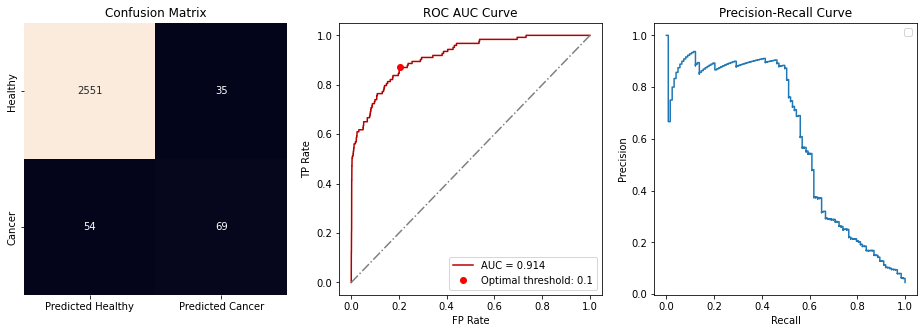

In [9]:
analytics_util.get_report_generation_util().display_graph()

In [10]:
def isin_filter(df: pd.DataFrame, col: str, values: List):
    return df[df[col].isin(values)]

# filtered_on = list(itertools.chain.from_iterable([zip([key]*len(vals), vals) for key, vals in differentiate_confusion_matrix_over.items()]))
# TODO: finish this one
differentiate_confusion_matrix_over = {
    'was_screened': [
        ([0], lambda df: isin_filter(df, 'was_screened', [0])), 
        ([1], lambda df: isin_filter(df, 'was_screened', [1]))
    ], 
    'ovar_histtype': [[2], [2, 4, 6, 8, 9, 31]]
}

In [11]:
# Get cv split
# run cv classifiers
# aggregate cv results
# visualize cv results
# save cv results
class CvAnalyticsUtil:
    def __init__(self, analytics_utils: List[AnalyticsUtil], missing_df: pd.DataFrame) -> None:
        self.analytics_utils = analytics_utils
        self.missing_df = missing_df
    
    def run_experiment_on_filter(self, filter):
        # TODO: run experiment on particular filter
        # filtered_on = list(itertools.chain.from_iterable([zip([key]*len(vals), vals) for key, vals in differentiate_confusion_matrix_over.items()]))
        # for i, (X_test_filtered, y_test_filtered) in enumerate(differentiated_test_sets):
        #     print(f'Filtered on: {filtered_on[i]}')                
        #     y_pred = trained_classifier.predict(X_test_filtered)
        #     y_prob = trained_classifier.predict_proba(X_test_filtered)[:,1]
        #     performance_analysis(y_pred, y_prob, y_test_filtered, show_graph=True)
        pass

    def get_cv_report(self):
        cv_scores = []
        for k, analytics_util in enumerate(self.analytics_utils):
            report = analytics_util.get_report_generation_util().generate_report().get_report()
            cv_scores.append(report)
        cv_scores = pd.concat(cv_scores)
        cv_scores = cv_scores.reset_index()
        cv_scores = cv_scores.drop('index', axis=1)
        measures_df = cv_scores.describe().T[['mean', 'std', 'min', 'max']]
        print('\n\nCross-Validation measures:')
        print_df(measures_df)
        return cv_scores, measures_df

    def get_confusion_matrix(self):
        confusion_matirices = []
        for k, analytics_util in enumerate(self.analytics_utils):
            cm = analytics_util.get_report_generation_util().get_confusion_matrix()
            confusion_matirices.append(cm)
        columns=confusion_matirices[0].columns
        index=confusion_matirices[0].index
        cv_cm = np.array(confusion_matirices)
        cv_cm = cv_cm.mean(axis=0)
        cv_cm = cv_cm.round(0)
        return pd.DataFrame(cv_cm, columns=columns, index=index).astype(np.int16)
    
    def roc_with_interval(self):
        fpr_mean    = np.linspace(0, 1, 100)
        interp_tprs = []
        thresholds_list = []
        for k, analytics_util in enumerate(self.analytics_utils):
            fpr, tpr, thresholds = analytics_util.get_report_generation_util().get_roc_results_interp()
            interp_tprs.append(tpr)
            thresholds_list.append(thresholds)
        tpr_mean     = np.mean(interp_tprs, axis=0)
        tpr_mean[-1] = 1.0
        tpr_std      = np.std(interp_tprs, axis=0)
        thresholds_mean = np.mean(thresholds_list, axis=0)
        return fpr_mean, tpr_mean, thresholds_mean, tpr_std*1.96

    def precision_recall_with_interval(self):
        recall_mean    = np.linspace(0, 1, 100)
        interp_precision = []
        for k, analytics_util in enumerate(self.analytics_utils):
            precision, recall = analytics_util.get_report_generation_util().get_precison_recall_results_interp()
            interp_precision.append(precision)
        precision_mean     = np.mean(interp_precision, axis=0)
        precision_std      = np.std(interp_precision, axis=0)
        return precision_mean, recall_mean, precision_std*1.96
    
    def store_cv_results(self):
        # TODO: inject base directory?
        # I assume that all of the analytics_utils have the same classifier type
        classifier_type = self.analytics_utils[0].classifier.__class__.__name__
        cv_scores, measures_df = self.get_cv_report()
        cv_scores.to_csv(f'./cv_scores/cv_scores_for_{classifier_type}_{label}.csv')
        measures_df.to_csv(f'./cv_scores/cv_stats_for_{classifier_type}_{label}.csv')

    def update_thresholds(self):
        # TODO: update thresholds for each of the analytics utils
        pass
    
    def display_graph(self) -> VisualizationUtil:
        f, ax = plt.subplots(1, 3, figsize=(16, 5))
        plt.yticks(rotation = 0)
        visualization_util = VisualizationUtil()
        visualization_util.display_confusion_matrix(ax[0], self.get_confusion_matrix())
        visualization_util.display_roc_graph(ax[-2], *self.roc_with_interval())
        visualization_util.display_roc_threshold(ax[-2], *self.roc_with_interval())
        visualization_util.display_precision_recall(ax[-1], *self.precision_recall_with_interval())
        plt.show()
        return visualization_util


class FeatureImportanceCvAnalyticsUtil(CvAnalyticsUtil):
    def get_cv_feature_selection(self) -> pd.DataFrame:
        df_feature_importance_tree = None
        for k, analytics_util in enumerate(self.analytics_utils):
            fn=analytics_util.data_util.get_feature_names()
            top_feature_stats, feature_importances = analytics_util.feature_selection()
            feature_importances = feature_importances[feature_importances['importance'] > 0]
            if df_feature_importance_tree is not None:
                df_feature_importance_tree = df_feature_importance_tree.merge(feature_importances, on='column_name', how='outer', suffixes=[f'_tiral_{k}', f'_tiral_{k+1}'])
            else:
                df_feature_importance_tree = feature_importances
        # Mean of feature importance over trials
        df_feature_importance_mean = df_feature_importance_tree.drop('column_name', axis=1)
        df_feature_importance_mean = df_feature_importance_mean.T
        df_feature_importance_mean.columns = df_feature_importance_tree['column_name']
        df_feature_importance_mean = df_feature_importance_mean.astype('float')
        df_feature_importance_mean_describe = df_feature_importance_mean.describe().T
        df_feature_importance_mean_describe.sort_values('mean', ascending=False, inplace=True)
        # print(df_feature_importance_mean_describe.columns)
        df_feature_importance_mean_describe = df_feature_importance_mean_describe[['count', 'mean']]
        # print_df(df_feature_importance_mean_describe)
        df_feature_importance_mean_describe = df_feature_importance_mean_describe.merge(self.missing_df, on='column_name')
        return df_feature_importance_mean_describe
    
    def store_cv_results(self):
        super(FeatureImportanceCvAnalyticsUtil, self).store_cv_results()
        classifier_type = self.analytics_utils[0].classifier.__class__.__name__
        df_feature_importance_mean_describe = self.get_cv_feature_selection()
        num_folds = len(self.analytics_utils)
        df_feature_importance_mean_describe.to_csv(f'./feature_importance/feature_importance_mean_{classifier_type}_{label}__{num_folds}_trials.csv')
        

class ExperimentRunner:
    def __init__(self, 
                 classifier, 
                 experiment_data_helper: ExperimentDataHelper, 
                 missing_df: pd.DataFrame, 
                 num_folds: int = 10, 
                 test_n_folds: int = 1, 
                 n_repeats: int = 1) -> None:
        self.classifier = clone(classifier) 
        self.experiment_data_helper = experiment_data_helper
        # TODO: more elegant way to inject missing df
        self.missing_df = missing_df
        # Instead of running all folds just run several folds so that it is easier to bench test
        self.num_folds = num_folds
        self.test_n_folds = test_n_folds
        if self.test_n_folds is None:
            self.test_n_folds = self.num_folds * self.n_repeats
        # TODO: RepeatedStratifiedKFold instead of StratifiedKFold to run experiments
        self.n_repeats = n_repeats

    def get_analytics_util(self) -> AnalyticsUtil:
        if self.classifier.__class__.__name__ == 'DecisionTreeClassifier':
            return DesicionTreeAnalyticsUtil
        if self.classifier.__class__.__name__ == 'XGBClassifier':
            return XgbAnalyticsUtil
        return AnalyticsUtil

    def get_cv_analytics_util(self) -> CvAnalyticsUtil:
        if self.classifier.__class__.__name__ == 'DecisionTreeClassifier':
            return FeatureImportanceCvAnalyticsUtil
        if self.classifier.__class__.__name__ == 'XGBClassifier':
            return FeatureImportanceCvAnalyticsUtil
        return CvAnalyticsUtil
    
    def run_experiment(self) -> CvAnalyticsUtil:
        data_util_lambdas = experiment_data_helper.train_test_split_util.split_kfold(self.num_folds)
        analytics_utils = []
        for i in range(self.test_n_folds):
            data_util = data_util_lambdas[i]()
            analytics_util = self.get_analytics_util()(self.classifier, data_util).fit()
            analytics_utils.append(analytics_util)
        return self.get_cv_analytics_util()(analytics_utils, self.missing_df)

In [19]:
experiment_runner = ExperimentRunner(classifier, experiment_data_helper, missing_df, test_n_folds=3)
cv_analytics_util = experiment_runner.run_experiment()

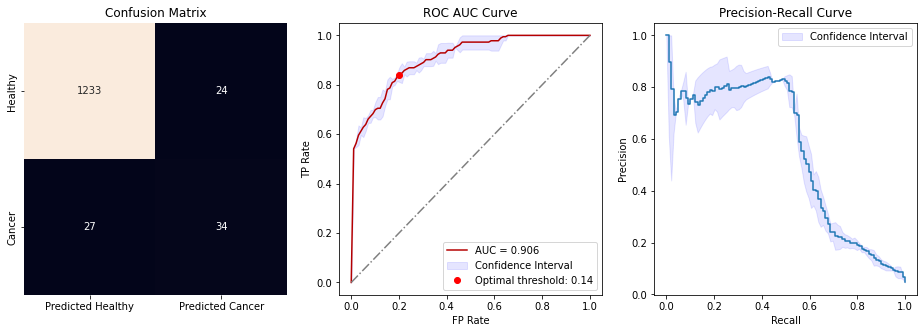

In [20]:
cv_analytics_util.display_graph()

In [14]:
cv_analytics_util.get_confusion_matrix()

,Predicted Healthy,Predicted Cancer
Healthy,1230,27
Cancer,27,34


In [15]:
cv_analytics_util.analytics_utils[0].get_report_generation_util().generate_report().get_report()

,precision__class_0,recall__class_0,f1-score__class_0,precision__class_1,recall__class_1,f1-score__class_1,accuracy,auc
0,0.980096,0.979316,0.979706,0.580645,0.590164,0.585366,0.961305,0.902983


In [16]:
# TODO: get high confidence mismatches
# fp_mismatches = get_high_confidence_errors(classifier, X_train, X_test, y_train, y_test, label, label_val=0)

def scale_features(df):
    sc = StandardScaler()
    df_scaled = df.copy()
    df_scaled = sc.fit_transform(df_scaled)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)
    return df_scaled

def get_nearest_neighbors(df1, df2, top=5):
    df1 = df1.drop_duplicates()
    df2 = df2.drop_duplicates()
    df1 = scale_features(df1)
    df2 = scale_features(df2)
    euclidean_distances = []
    indexes = []
    for i in range(len(df1)):
        row1 = df1.iloc[i]
        distances = []
        for j, row2 in df2.iterrows():
            distances.append((j, distance.euclidean(row1, row2)))
        distances = sorted(distances, key=lambda x: x[1], reverse=False)[:top]
        distances = pd.DataFrame(distances, columns=['index', 'distance'])
        indexes.append((distances['index'].to_list()))
        euclidean_distances.append(distances['distance'].to_list())
    return euclidean_distances, indexes

def get_high_confidence_errors(classifier, X_train, X_test, y_train, y_test, label, label_val=0):
    # Insert predicted class and its likelihood
    X_train = X_train.copy()
    X_test = X_test.copy()
    y_pred = classifier.predict(X_test)
    y_prob = classifier.predict_proba(X_test)[:,1]
    X_test_mismatch = X_test.copy()
    X_test_mismatch[label] = y_test
    X_test_mismatch[f'{label}_pred'] = y_pred
    X_test_mismatch[f'{label}_prob'] = y_prob
    X_test_mismatch = X_test_mismatch.drop_duplicates()
    X_test_mismatch = X_test_mismatch[X_test_mismatch[label] != X_test_mismatch[f'{label}_pred']]
    
    # X_test_high_conf = X_test_mismatch[(X_test_mismatch[f'{label}_prob'] < 0.2) | (X_test_mismatch[f'{label}_prob'] > 0.8)]
    X_test_high_conf = X_test_mismatch
    X_test_high_conf = X_test_high_conf[X_test_high_conf[f'{label}_pred'] == label_val]
    
    # Select 5 nearest neightbors 
    X_train[label] = y_train
    X_train_filtered = X_train[X_train[label] == label_val].drop(label, axis=1)
    # X_test_high_conf = X_test.loc[X_test_high_conf.index, :]
    # Calculated euclidean distances
    distances, indices = get_nearest_neighbors(X_test.loc[X_test_high_conf.index, :], X_train_filtered)
    fp_mismatches = []
    X_train[f'{label}_pred'] = -1
    X_train[f'{label}_prob'] = -1
    X_train = X_train.drop_duplicates()
    # print_df(X_train)
    for i in range(len(X_test_high_conf)):
        idx = indices[i]
        missed_record = X_test_high_conf.iloc[[i], :]
        missed_record['distance'] = 0
        close_records = X_train.loc[idx, :]
        close_records['distance'] = distances[i]
        fp_mismatches.append((missed_record, close_records))
    return fp_mismatches

